# Time Series problem: Predvidjanje kretanja prodaja u zavistonsti od razlicitih scenarija

- **Trend:** `flat` (neutral), `up` (rising), `down` (falling)  
- **Seasonality:** `none`, `monthly`, `yearly`, `monthly+yearly`

U obzir su uzeti i neradni dani u Srbiji u skadu sa zakonom
Takodje postoje i scenariji sa nepravilnim unosom podataka.


## 1) Import biblioteka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, timedelta

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(42)


## 2) Generisanje neradnih dana

In [2]:
def orthodox_easter_gregorian(year: int) -> date:
    """Proracun za pravoslavni uskrs, posto se menja svake godine"""
    a = year % 4
    b = year % 7
    c = year % 19
    d = (19 * c + 15) % 30
    e = (2 * a + 4 * b - d + 34) % 7
    month = (d + e + 114) // 31
    day_ = ((d + e + 114) % 31) + 1
    julian_easter = date(year, month, day_)
    return julian_easter + timedelta(days=13)  # Julian -> Gregorian for 1900–2099

def serbia_public_holidays(year: int) -> dict[date, str]:
    """Drzavni praznici zajedno sa uskrsom"""
    holidays = {
        date(year, 1, 1): "New Year's Day",
        date(year, 1, 2): "New Year's Day",
        date(year, 1, 7): "Julian Orthodox Christmas",
        date(year, 2, 15): "Statehood Day",
        date(year, 2, 16): "Statehood Day",
        date(year, 5, 1): "Labour Day",
        date(year, 5, 2): "Labour Day",
        date(year, 11, 11): "Armistice Day",
    }

    easter = orthodox_easter_gregorian(year)
    holidays.update({
        easter + timedelta(days=-2): "Orthodox Good Friday",
        easter + timedelta(days=-1): "Orthodox Holy Saturday",
        easter + timedelta(days=0): "Orthodox Easter Sunday",
        easter + timedelta(days=1): "Orthodox Easter Monday",
    })

    # Zakon: Ako jedan od datuma kada se praznuju državni praznici Republike Srbije padne u nedelju, ne radi se prvog narednog radnog dana.
    state_holidays = {"New Year's Day", "Statehood Day", "Labour Day", "Armistice Day"}
    all_dates = set(holidays.keys())

    non_rel_dates = [d for d, name in holidays.items() if name in state_holidays]
    for d in sorted(non_rel_dates):
        if d.weekday() == 6:  # Sunday
            obs = d + timedelta(days=1)
            while obs.weekday() >= 5 or obs in all_dates:
                obs += timedelta(days=1)
            holidays[obs] = holidays[d] + " (observed)"
            all_dates.add(obs)

    return holidays

def serbia_holiday_map_for_range(start: str, end: str) -> dict[pd.Timestamp, str]:
    """Return {Timestamp: name} for all holidays between start and end (inclusive)."""
    start_dt = pd.Timestamp(start).date()
    end_dt = pd.Timestamp(end).date()
    years = range(start_dt.year, end_dt.year + 1)
    out = {}
    for y in years:
        for d, name in serbia_public_holidays(y).items():
            if start_dt <= d <= end_dt:
                out[pd.Timestamp(d)] = name
    return out

# Quick demo: list holidays in 2026
demo = serbia_public_holidays(2026)
sorted(list(demo.items()))[:]


[(datetime.date(2026, 1, 1), "New Year's Day"),
 (datetime.date(2026, 1, 2), "New Year's Day"),
 (datetime.date(2026, 1, 7), 'Julian Orthodox Christmas'),
 (datetime.date(2026, 2, 15), 'Statehood Day'),
 (datetime.date(2026, 2, 16), 'Statehood Day'),
 (datetime.date(2026, 2, 17), 'Statehood Day (observed)'),
 (datetime.date(2026, 4, 10), 'Orthodox Good Friday'),
 (datetime.date(2026, 4, 11), 'Orthodox Holy Saturday'),
 (datetime.date(2026, 4, 12), 'Orthodox Easter Sunday'),
 (datetime.date(2026, 4, 13), 'Orthodox Easter Monday'),
 (datetime.date(2026, 5, 1), 'Labour Day'),
 (datetime.date(2026, 5, 2), 'Labour Day'),
 (datetime.date(2026, 11, 11), 'Armistice Day')]

## 3) Generisanje podataka na osnovu trendova

In [3]:
def generate_daily_sales(
    start: str = "2023-01-01",
    periods: int = 730,
    base_level: float = 30.0,
    trend: str = "flat",                 # 'flat' | 'up' | 'down'
    seasonality: str = "monthly+yearly", # 'none' | 'monthly' | 'yearly' | 'monthly+yearly'
    weekly_pattern: bool = True,

    close_sundays: bool = True,
    close_saturdays: bool = False,
    close_on_public_holidays: bool = True,

    # Noise / outliers
    noise_scale: float = 0.20,           # multiplicative noise strength
    spike_prob: float = 0.02,            # random spikes (outliers)
    spike_mult_range: tuple = (1.1, 2.3),
    overdispersion_k: float = 12.0,      # lower => more variance; higher => more Poisson-like

    # BAD USER INPUT SCENARIO:
    # user enters weekly totals only once per week (at end of week, not necessarily Friday)
    weekly_batch_input: bool = False,
    weekly_batch_last_k_days: int = 3,   # choose the entry day among the last K days of each week
) -> pd.DataFrame:
    """
    If weekly_batch_input=True:
      - We still generate a realistic *true* daily series (sales_true)
      - Then we convert the observed 'sales' into a once-per-week lump:
        the week sum is entered on a random day among the last K days of the week,
        and other days are set to 0.
    """
    dates = pd.date_range(start=start, periods=periods, freq="D")
    t = np.arange(periods, dtype=float)

    # Trend (smooth)
    if trend == "flat":
        growth_rate = 0.00
    elif trend == "up":
        growth_rate = 0.35
    elif trend == "down":
        growth_rate = -0.25
    else:
        raise ValueError("trend must be one of: 'flat', 'up', 'down'")

    level = base_level * np.power(1.0 + growth_rate, t / 365.25)
    level = np.maximum(1.0, level)

    # Monthly/Yearly seasonality (additive)
    seasonal = np.zeros_like(t)
    if seasonality in ("monthly", "monthly+yearly"):
        seasonal += 0.25 * base_level * np.sin(2 * np.pi * t / 30.4375)
    if seasonality in ("yearly", "monthly+yearly"):
        seasonal += 0.40 * base_level * np.sin(2 * np.pi * t / 365.25)

    # Weekly pattern (multiplicative)
    if weekly_pattern:
        dow = dates.dayofweek.values # vraca niz od vrednosti dana [0-6]
        # Mon..Sun multipliers (example pattern)
        dow_mult = np.array([1.00, 1.03, 1.05, 1.02, 1.12, 1.18, 0.78])
        weekly_mult = dow_mult[dow]
    else:
        weekly_mult = 1.0

    # Serbia public holidays
    hol_map = serbia_holiday_map_for_range(dates.min().strftime("%Y-%m-%d"), dates.max().strftime("%Y-%m-%d"))
    holiday_name = pd.Series(index=dates, data=[hol_map.get(d.normalize(), "") for d in dates], dtype="string")
    is_holiday = holiday_name.ne("") # creates bool array

    # Closed policy
    is_weekend = (dates.dayofweek.values >= 5)
    is_closed = np.zeros(periods, dtype=bool)
    # |= je kao  is_closed = is_closed OR (dates.dayofweek.values == 5)
    if close_saturdays:
        is_closed |= (dates.dayofweek.values == 5)
    if close_sundays:
        is_closed |= (dates.dayofweek.values == 6)
    if close_on_public_holidays:
        is_closed |= is_holiday.values

    # Expected mean (before spikes/noise)
    mu = (level + seasonal) * weekly_mult
    mu = np.maximum(0.1, mu)

    # Random spikes (not on closed days)
    spike = (np.random.rand(periods) < spike_prob) & (~is_closed)
    spike_mult = np.ones(periods)
    spike_mult[spike] = np.random.uniform(spike_mult_range[0], spike_mult_range[1], size=int(spike.sum()))
    mu *= spike_mult

    # Multiplicative noise
    eps = np.random.normal(0.0, noise_scale, size=periods)
    mu_noisy = mu * np.exp(eps)
    mu_noisy = np.maximum(0.0, mu_noisy)

    # Force closed days to zero demand
    mu_noisy[is_closed] = 0.0

    # Sample counts via Negative Binomial (extra variance)
    k = float(overdispersion_k) # larger k value gives smoother results
    sales = np.zeros(periods, dtype=int)
    nz = mu_noisy > 0
    mu_nz = mu_noisy[nz]
    p = k / (k + mu_nz)
    sales[nz] = np.random.negative_binomial(n=k, p=p, size=mu_nz.shape[0]).astype(int)

    # Keep the true daily signal
    sales_true = sales.copy()
    weekly_entry = np.zeros(periods, dtype=bool)

    # BAD INPUT: weekly batch entry at end of week (random day among last K days)
    if weekly_batch_input:
        sales_obs = np.zeros_like(sales_true)
        # Week from Monday..Sunday (ends Sunday)
        wk = dates.to_period("W-SUN")
        for w in pd.unique(wk):
            idx = np.where(wk == w)[0]
            if idx.size == 0:
                continue
            week_total = int(sales_true[idx].sum())

            # choose among last K days in the week (or fewer if week is short at edges)
            k_days = int(max(1, weekly_batch_last_k_days))
            candidates = idx[-k_days:]
            chosen = int(np.random.choice(candidates))

            sales_obs[chosen] = week_total
            weekly_entry[chosen] = True

        sales = sales_obs

    return pd.DataFrame({
        "date": dates,
        "sales": sales,                 # observed sales (may be weekly-batched)
        "sales_true": sales_true,       # underlying true daily sales
        "mu": mu_noisy,                 # expected mean (daily)
        "is_weekend": is_weekend,
        "is_holiday": is_holiday.values,
        "holiday_name": holiday_name.values,
        "is_closed": is_closed,
        "spike": spike,
        "weekly_entry": weekly_entry,   # True on the day user entered weekly total (bad input scenario)
        "weekly_batch_input": weekly_batch_input,
    })

# Smoke tests
generate_daily_sales(trend="up", seasonality="monthly+yearly", periods=30, weekly_batch_input=False).head(),
generate_daily_sales(trend="up", seasonality="monthly+yearly", periods=30, weekly_batch_input=True).head()


,date,sales,sales_true,mu,is_weekend,is_holiday,holiday_name,is_closed,spike,weekly_entry,weekly_batch_input
0,2023-01-01,0,0,0.000000,True,True,New Year's Day,True,False,True,True
1,2023-01-02,0,0,0.000000,False,True,New Year's Day,True,False,False,True
2,2023-01-03,0,0,0.000000,False,True,New Year's Day (observed),True,False,False,True
3,2023-01-04,0,48,47.965692,False,False,,False,False,False,True
4,2023-01-05,0,53,43.046286,False,False,,False,False,False,True


## 4) Kreiranje scenarija (3 trends x 4 seasonalities = 12 clean series + 1 bad user input)

In [4]:
TRENDS = ["flat", "up", "down"]
SEASONALITIES = ["none", "monthly", "yearly", "monthly+yearly"]

scenarios = {}
for tr in TRENDS:
    for seas in SEASONALITIES:
        key = f"{tr}__{seas}"
        scenarios[key] = generate_daily_sales(
            start="2025-01-01",
            periods=3 * 365,
            base_level=35.0,
            trend=tr,
            seasonality=seas,
            weekly_pattern=True,
            close_sundays=True,
            close_saturdays=False,
            close_on_public_holidays=True,
            noise_scale=0.18,
            spike_prob=0.02,
            overdispersion_k=10.0,
            weekly_batch_input=False,
        )

# Single "bad user input" scenario: weekly batch entry at end of week
scenarios["bad_user_input"] = generate_daily_sales(
    start="2025-01-01",
    periods=3 * 365,
    base_level=35.0,
    trend="flat",
    seasonality="monthly+yearly",
    weekly_pattern=True,
    close_sundays=True,
    close_saturdays=False,
    close_on_public_holidays=True,
    noise_scale=0.18,
    spike_prob=0.02,
    overdispersion_k=10.0,
    weekly_batch_input=True,
    weekly_batch_last_k_days=3,   # entry day among last 3 days of week (not necessarily Friday)
)

list(scenarios.keys())[:], len(scenarios)


(['flat__none',
  'flat__monthly',
  'flat__yearly',
  'flat__monthly+yearly',
  'up__none',
  'up__monthly',
  'up__yearly',
  'up__monthly+yearly',
  'down__none',
  'down__monthly',
  'down__yearly',
  'down__monthly+yearly',
  'bad_user_input'],
 13)

## 4b) Cuvanje podataka u CSV fajlove

In [5]:
from pathlib import Path

out_dir = Path("Data")
out_dir.mkdir(parents=True, exist_ok=True)

# After creating full datasets, also export fixed-length subsets for benchmarking
SUBSET_DAYS = [30, 100, 300]     # you can add more here
SUBSET_ANCHOR = "last"           # 'last' or 'first'

saved = 0
saved_sub = 0

for name, df_s in scenarios.items():
    # Full dataset
    df_s.to_csv(out_dir / f"{name}.csv", index=False)
    saved += 1

    # Subsets
    for n in SUBSET_DAYS:
        if len(df_s) < n:
            continue
        df_sub = df_s.tail(n) if SUBSET_ANCHOR == "last" else df_s.head(n)
        suffix = f"{SUBSET_ANCHOR}{n}d"
        df_sub.to_csv(out_dir / f"{name}__{suffix}.csv", index=False)
        saved_sub += 1

print(f"Saved {saved} full scenario CSV files into: {out_dir.resolve()}")
print(f"Saved {saved_sub} subset CSV files (sizes={SUBSET_DAYS}, anchor='{SUBSET_ANCHOR}')")
print("Example files:", sorted([p.name for p in out_dir.glob('*.csv')])[:8])


Saved 13 full scenario CSV files into: /python-roi/python-roi/Data
Saved 39 subset CSV files (sizes=[30, 100, 300], anchor='last')
Example files: ['bad_user_input.csv', 'bad_user_input__last100d.csv', 'bad_user_input__last300d.csv', 'bad_user_input__last30d.csv', 'down__monthly+yearly.csv', 'down__monthly+yearly__last100d.csv', 'down__monthly+yearly__last300d.csv', 'down__monthly+yearly__last30d.csv']


## 5) Vizuelizacija podataka

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def load_sales_csv(path: Path) -> pd.DataFrame:
    """Load a CSV with at least: date, sales. Extra columns are kept if present."""
    df = pd.read_csv(path)
    if "date" not in df.columns:
        raise ValueError("CSV must contain a 'date' column")
    if "sales" not in df.columns:
        raise ValueError("CSV must contain a 'sales' column")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")
    return df

def plot_range(df_full: pd.DataFrame, start, end, shade_closed: bool = True, mark_spikes: bool = True):
    """Plot full series + zoomed range + rolling mean."""
    if start is None or end is None:
        return
    start_ts = pd.Timestamp(start)
    end_ts = pd.Timestamp(end)
    if start_ts > end_ts:
        start_ts, end_ts = end_ts, start_ts

    df_zoom = df_full.loc[start_ts:end_ts].copy()

    # Plot A: full series with selected range highlighted
    plt.figure(figsize=(14, 3.5))
    ax = plt.gca()
    ax.plot(df_full.index.to_pydatetime(), df_full["sales"].values, linewidth=1)
    # Trend line (simple linear fit) over the full series
    s_full = df_full["sales"].dropna()
    if len(s_full) >= 2:
        x = np.arange(len(s_full), dtype=float)
        m, b = np.polyfit(x, s_full.values.astype(float), 1)
        trend = m * x + b
        ax.plot(s_full.index.to_pydatetime(), trend, color="red", linewidth=2, label="trend")
    plt.axvspan(start_ts, end_ts + pd.Timedelta(days=1), alpha=0.12)
    plt.title("Full series (selected range highlighted)")
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot B: zoomed range
    plt.figure(figsize=(14, 4))
    ax = plt.gca()
    ax.plot(df_zoom.index.to_pydatetime(), df_zoom["sales"].values, linewidth=1)

    # Trend line (simple linear fit) over the zoomed window
    s_zoom = df_zoom["sales"].dropna()
    if len(s_zoom) >= 2:
        xz = np.arange(len(s_zoom), dtype=float)
        m2, b2 = np.polyfit(xz, s_zoom.values.astype(float), 1)
        trend2 = m2 * xz + b2
        ax.plot(s_zoom.index.to_pydatetime(), trend2, color="red", linewidth=2, label="trend")
    # Optional: mark spikes if column exists
    if mark_spikes and "spike" in df_zoom.columns:
        spike_days = df_zoom.index[df_zoom["spike"].astype(bool)]
        if len(spike_days) > 0:
            plt.scatter(spike_days.to_pydatetime(), df_zoom.loc[spike_days, "sales"], s=18, label="spike", zorder=3)

    # Optional: mark weekly-entry (bad input) if column exists
    if "weekly_entry" in df_zoom.columns:
        we_days = df_zoom.index[df_zoom["weekly_entry"].astype(bool)]
        if len(we_days) > 0:
            plt.scatter(we_days.to_pydatetime(), df_zoom.loc[we_days, "sales"], s=28, marker="x", label="weekly entry", zorder=4)

    # Optional: shade closed days if column exists
    if shade_closed and "is_closed" in df_zoom.columns:
        closed_days = df_zoom.index[df_zoom["is_closed"].astype(bool)]
        for d in closed_days:
            plt.axvspan(d, d + pd.Timedelta(days=1), alpha=0.08)

    plt.title(f"Zoomed range: {start_ts.date()} → {end_ts.date()}  (rows={len(df_zoom)})")
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot C: zoomed 7-day rolling mean
    plt.figure(figsize=(14, 3.5))
    ax = plt.gca()
    roll = df_zoom["sales"].rolling(7).mean()
    ax.plot(roll.index.to_pydatetime(), roll.values, linewidth=1)
    plt.title("Zoomed range — 7-day rolling mean (smoother view)")
    plt.xlabel("date")
    plt.ylabel("sales (7d mean)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




## 5b) Izbor podataka

In [7]:
import ipywidgets as widgets
from IPython.display import display
    

# This cell builds a small interactive UI (dropdowns + date pickers) so you can:
# 1) choose which CSV file to load from the Data folder
# 2) choose a time window (All / Last N / Custom)
# 3) update a global df_current that later cells (STL / forecasting) will use

data_dir = Path("Data")
data_dir.mkdir(parents=True, exist_ok=True)

csv_files = sorted(data_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError(
        "No CSV files found in ./Data\n"
        "Run the scenario generation + saving cell first, "
        "OR copy your CSV into ./Data"
    )

# preferred filename
preferred_name = "flat__yearly.csv"

# try to find preferred file
preferred_path = next(
    (f for f in csv_files if f.name == preferred_name),
    None
)

# fallback logic
default_path = preferred_path if preferred_path else csv_files[0]

print(f"Using CSV file: {default_path.name}")

df_loaded = load_sales_csv(default_path)

# Global df_current used by later cells (STL/forecast). It will be updated to the selected window.
df_current = df_loaded.copy()



file_dd = widgets.Dropdown(
    options=[p.name for p in csv_files],
    value=default_path.name,
    description="CSV:",
    layout=widgets.Layout(width="650px"),
)

window_dd = widgets.Dropdown(
    options=["All", "Last 30", "Last 100", "Last 300", "Custom"],
    value="All",
    description="Window:",
    layout=widgets.Layout(width="250px"),
)

anchor_dd = widgets.Dropdown(
    options=["Last", "First"],
    value="Last",
    description="Anchor:",
    layout=widgets.Layout(width="200px"),
)

start_picker = widgets.DatePicker(description="Start:", value=df_loaded.index.min().date())
end_picker = widgets.DatePicker(description="End:", value=df_loaded.index.max().date())

shade_cb = widgets.Checkbox(value=True, description="Shade closed days (if column exists)")
spikes_cb = widgets.Checkbox(value=True, description="Mark spikes (if column exists)")

out = widgets.Output()

def _set_picker_safely(picker, value):
    """Set DatePicker value without triggering a refresh loop."""
    if picker.value == value:
        return
    try:
        picker.unobserve(refresh_plot, names="value")
    except Exception:
        pass
    picker.value = value
    try:
        picker.observe(refresh_plot, names="value")
    except Exception:
        pass

def _set_dropdown_safely(dropdown, value):
    """Set Dropdown value without triggering nested refresh_plot calls."""
    if dropdown.value == value:
        return
    try:
        dropdown.unobserve(refresh_plot, names="value")
    except Exception:
        pass
    dropdown.value = value
    try:
        dropdown.observe(refresh_plot, names="value")
    except Exception:
        pass

def refresh_plot(*args):
    # If you manually change Start/End DatePicker, switch Window to Custom automatically.
    # Otherwise (All / Last N) the code will overwrite your picked dates with the computed window.
    if args and isinstance(args[0], dict):
        owner = args[0].get("owner", None)
        if owner in (start_picker, end_picker) and window_dd.value != "Custom":
            _set_dropdown_safely(window_dd, "Custom")

    global df_current
    with out:
        out.clear_output(wait=True)
        path = data_dir / file_dd.value
        df_now = load_sales_csv(path)

        min_d = df_now.index.min()
        max_d = df_now.index.max()

        # Decide the window
        if window_dd.value == "All":
            start_ts, end_ts = min_d, max_d
        elif window_dd.value in ("Last 30", "Last 100", "Last 300"):
            n = int(window_dd.value.split()[-1])
            if anchor_dd.value == "Last":
                end_ts = max_d
                start_ts = max(min_d, end_ts - pd.Timedelta(days=n - 1))
            else:
                start_ts = min_d
                end_ts = min(max_d, start_ts + pd.Timedelta(days=n - 1))
        else:
            # Custom: use pickers, but clamp to available range
            sp = pd.Timestamp(start_picker.value) if start_picker.value else min_d
            ep = pd.Timestamp(end_picker.value) if end_picker.value else max_d
            start_ts = max(min_d, min(sp, max_d))
            end_ts = min(max_d, max(ep, min_d))

        # Update date pickers to reflect chosen window (safe: prevents refresh loop)
        if window_dd.value != "Custom":
            _set_picker_safely(start_picker, start_ts.date())
            _set_picker_safely(end_picker, end_ts.date())
# IMPORTANT: df_current becomes the selected window (so STL/forecast uses 30/100/300 days if you choose that)
        df_current = df_now.loc[start_ts:end_ts].copy()

        plot_range(df_now, start_ts, end_ts, shade_closed=shade_cb.value, mark_spikes=spikes_cb.value)

for w in (file_dd, window_dd, anchor_dd, start_picker, end_picker, shade_cb, spikes_cb):
    w.observe(refresh_plot, names="value")

controls = widgets.VBox([
    file_dd,
    widgets.HBox([window_dd, anchor_dd]),
    widgets.HBox([start_picker, end_picker]),
    shade_cb,
    spikes_cb
])
display(controls, out)
refresh_plot()

Using CSV file: flat__yearly.csv


Output()

## 5c) Podela na trening i test (po datumu)

In [8]:
# 5c) Podela na trening i test (po datumu)
# Ova sekcija koristi df_current iz 5b (izabrani fajl + prozor) i onda ti omogućava
# da odrediš tačan date range za trening i test.
#
# Rezultat:
# - df_train, df_test (global)  -> koriste se za fit/evaluaciju u forecast ćeliji
# - df_current (global)         -> postavljamo na df_train, da STL/ACF rade nad trening skupom

try:
    df_window = df_current.copy()
except NameError:
    raise RuntimeError("df_current nije definisan. Pokreni 5b (Izbor podataka) pre 5c.")

if "sales" not in df_window.columns:
    raise RuntimeError("Očekujem kolonu 'sales' u df_current. Proveri CSV format.")

# Uveri se da je index datetime i sortiran
df_window = df_window.sort_index()
df_window = df_window[~df_window.index.duplicated(keep="last")]

min_d = df_window.index.min()
max_d = df_window.index.max()

# Default: poslednjih 30 dana je test (ako ima dovoljno podataka)
_default_test_days = 250
# Za kratke serije (npr. 30/100 dana) 250 nema smisla -> koristi 20% (min 7 dana).
# Za duže serije (>=300 dana) default je 250 (traži maksimalnu tačnost za dugi horizon).
if len(df_window) < 300:
    _default_test_days = max(7, int(len(df_window) * 0.2))
test_end_default = max_d
test_start_default = max(min_d, test_end_default - pd.Timedelta(days=_default_test_days - 1))
train_start_default = min_d
train_end_default = test_start_default - pd.Timedelta(days=1)

import ipywidgets as widgets
from IPython.display import display

train_start = widgets.DatePicker(description="Train start:", value=train_start_default.date())
train_end   = widgets.DatePicker(description="Train end:",   value=train_end_default.date())
test_start  = widgets.DatePicker(description="Test start:",  value=test_start_default.date())
test_end    = widgets.DatePicker(description="Test end:",    value=test_end_default.date())

# Brzi izbor test dužine (opciono)
quick_test = widgets.Dropdown(
    options=["Custom", "Last 30", "Last 100", "Last 300"],
    value="Custom" if _default_test_days != 30 else "Last 30",
    description="Quick test:",
    layout=widgets.Layout(width="220px")
)

apply_btn = widgets.Button(description="Apply split", button_style="")
out = widgets.Output()

def _clamp_ts(ts):
    ts = pd.Timestamp(ts)
    if ts < min_d:
        return min_d
    if ts > max_d:
        return max_d
    return ts

def _set_picker(picker, value_date):
    # set DatePicker without extra logic/loops (we don't auto-refresh anyway)
    picker.value = value_date

def _apply_quick_test(choice):
    # Set test range to "last N" and train to everything before it (no overlap)
    if choice == "Custom":
        return

    n = int(choice.split()[-1])
    end_test = max_d
    start_test = max(min_d, end_test - pd.Timedelta(days=n - 1))
    end_train = start_test - pd.Timedelta(days=1)

    # If the dataset is too short, end_train may fall before min_d
    if end_train < min_d:
        end_train = min_d

    _set_picker(test_end, end_test.date())
    _set_picker(test_start, start_test.date())
    _set_picker(train_start, min_d.date())
    _set_picker(train_end, end_train.date())

def _make_split(df_now, tr_s, tr_e, te_s, te_e):
    tr_s = _clamp_ts(tr_s)
    tr_e = _clamp_ts(tr_e)
    te_s = _clamp_ts(te_s)
    te_e = _clamp_ts(te_e)

    # normalize inside each range
    if tr_e < tr_s:
        tr_s, tr_e = tr_e, tr_s
    if te_e < te_s:
        te_s, te_e = te_e, te_s

    # no overlap: train end must be before test start
    if tr_e >= te_s:
        raise ValueError("Nevažeći split: TRAIN_END mora biti pre TEST_START (bez preklapanja).")

    df_tr = df_now.loc[tr_s:tr_e].copy()
    df_te = df_now.loc[te_s:te_e].copy()

    if len(df_tr) == 0:
        raise ValueError("Trening opseg je prazan (0 redova).")
    if len(df_te) == 0:
        raise ValueError("Test opseg je prazan (0 redova).")

    return df_tr, df_te

def apply_split(_=None):
    global df_train, df_test, df_current

    with out:
        out.clear_output(wait=True)
        import matplotlib.pyplot as plt
        plt.close("all")

        # optional quick preset
        _apply_quick_test(quick_test.value)

        try:
            df_train, df_test = _make_split(
                df_window,
                train_start.value, train_end.value,
                test_start.value, test_end.value
            )
        except Exception as e:
            print("Split error:", e)
            return

        # STL/ACF da rade nad trening setom
        df_current = df_train.copy()

        print("WINDOW:", min_d.date(), "->", max_d.date(), f"(rows={len(df_window)})")
        print("TRAIN: ", df_train.index.min().date(), "->", df_train.index.max().date(), f"(rows={len(df_train)})")
        print("TEST:  ", df_test.index.min().date(),  "->", df_test.index.max().date(),  f"(rows={len(df_test)})")

        # plot
        plt.figure(figsize=(12, 4))
        plt.plot(df_window.index.to_pydatetime(), df_window["sales"].values, linewidth=1, label="sales")

        plt.axvspan(df_train.index.min().to_pydatetime(), df_train.index.max().to_pydatetime(), alpha=0.15, label="train")
        plt.axvspan(df_test.index.min().to_pydatetime(), df_test.index.max().to_pydatetime(), alpha=0.15, color="green", label="test")
        plt.axvline(df_test.index.min().to_pydatetime(), linestyle="--", linewidth=2)

        plt.title("Podela na trening i test (po datumu)")
        plt.xlabel("date")
        plt.ylabel("sales")
        plt.legend()
        plt.tight_layout()
        plt.show()

apply_btn.on_click(apply_split)

controls = widgets.VBox([
    widgets.HTML("<b>Izaberi date range za trening i test</b>"),
    quick_test,
    widgets.HBox([train_start, train_end]),
    widgets.HBox([test_start, test_end]),
    apply_btn
])

display(controls, out)
apply_split()

Output()

## 6) Diagnostics: STL decomposition + ACF (weekly/monthly/yearly signals)

Train rows: 845 | valid STL periods: [7, 30, 365]

Seasonality/Trend strength per period (STL on log1p(sales)):
  period=  7 | seasonal=0.730 (strong) | trend=0.057 (none)
  period= 30 | seasonal=0.030 (none) | trend=0.016 (none)
  period=365 | seasonal=0.806 (strong) | trend=0.005 (none)

Detected seasonality (threshold >= 0.20):
  period=  7: YES
  period= 30: NO
  period=365: YES

Selected seasonality for modeling (priority yearly > monthly > weekly): yearly | period: 365
Good seasonalities: ['yearly', 'weekly']

Trend (whole train, log1p regression):
  decision: NO
  direction: rising
  slope/day: 0.000079 | robust slope/day: 0.000000 (95% CI [-0.000064, 0.000050])
  R²: 0.000 | p-value: 0.698
  approx yearly factor (1+sales): 1.029 | approx total factor: 1.069 over 844 days

Summary: Seasonality=YES | Trend=NO


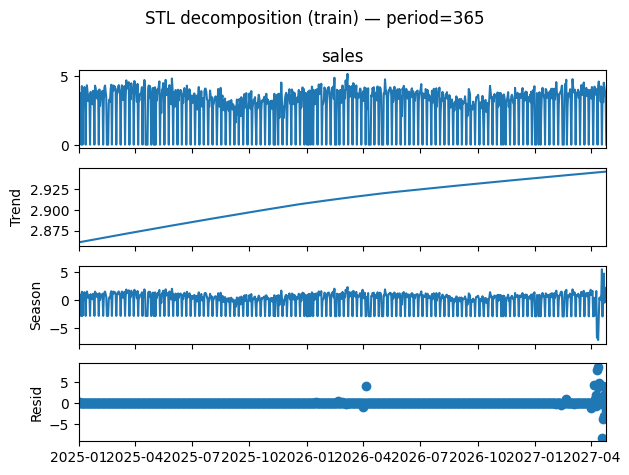

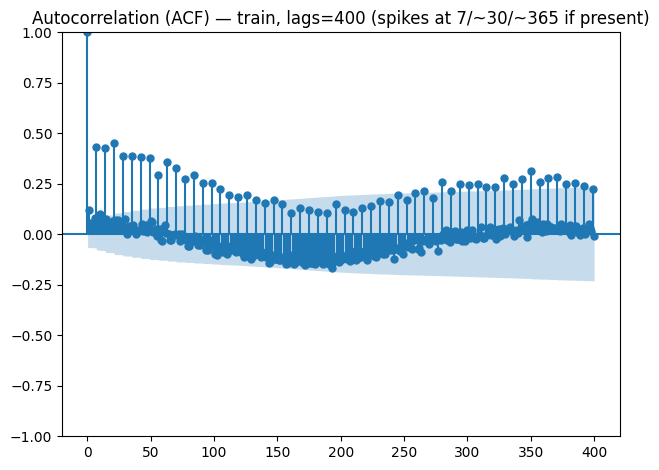

In [9]:
# 6) Diagnostics: STL decomposition + ACF (weekly/monthly/yearly signals)
# IMPORTANT: this section uses df_train

try:
    _train = df_train.copy()
except NameError:
    raise RuntimeError("df_train is not defined. Run Section 5c (train/test split) first.")

if "sales" not in _train.columns:
    raise RuntimeError("Expected column 'sales' in df_train. Check your CSV format.")

# Ensure clean, sorted DateTimeIndex
_train = _train.sort_index()
_train = _train[~_train.index.duplicated(keep="last")]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

# -----------------------------
# Helpers: strength + labeling
# -----------------------------
def _strength_label(v: float) -> str:
    if v >= 0.50:
        return "strong"
    if v >= 0.20:
        return "moderate"
    if v >= 0.10:
        return "weak"
    return "none"

def stl_strength(y: pd.Series, period: int, robust: bool = True):
    """Return (res, seasonal_strength, trend_strength) using Hyndman-style measures on log1p(y)."""
    y = y.astype(float).copy().clip(lower=0)
    y_log = np.log1p(y)

    res = STL(y_log, period=period, robust=robust).fit()
    seasonal, trend, resid = res.seasonal, res.trend, res.resid

    def _var(a):
        return float(np.var(a, ddof=0))

    denom_s = _var(resid + seasonal)
    denom_t = _var(resid + trend)

    seasonal_strength = max(0.0, 1.0 - (_var(resid) / denom_s)) if denom_s > 0 else 0.0
    trend_strength = max(0.0, 1.0 - (_var(resid) / denom_t)) if denom_t > 0 else 0.0

    return res, seasonal_strength, trend_strength

# -----------------------------
# A) Seasonality detection (STL per candidate period)
# -----------------------------
y = _train["sales"].dropna()
N = len(y)

candidate_periods = [7, 30, 365]  # daily data candidates
valid_periods = [p for p in candidate_periods if p >= 2 and N >= 2 * p]  # need ~2 cycles

print(f"Train rows: {N} | valid STL periods: {valid_periods if valid_periods else 'none'}")

SEASONAL_THR = 0.20  # "moderate or stronger"

period_results = []
for p in valid_periods:
    res_p, ss, ts = stl_strength(y, period=p, robust=True)
    period_results.append({"period": p, "seasonal_strength": ss, "trend_strength": ts, "res": res_p})

if period_results:
    print("\nSeasonality/Trend strength per period (STL on log1p(sales)):")
    for r in sorted(period_results, key=lambda d: d["period"]):
        p = r["period"]
        ss = r["seasonal_strength"]
        ts = r["trend_strength"]
        print(f"  period={p:>3} | seasonal={ss:.3f} ({_strength_label(ss)}) | trend={ts:.3f} ({_strength_label(ts)})")

    seasonality_by_period = {r["period"]: (r["seasonal_strength"] >= SEASONAL_THR) for r in period_results}

    print("\nDetected seasonality (threshold >= 0.20):")
    for p in sorted(seasonality_by_period):
        print(f"  period={p:>3}: {'YES' if seasonality_by_period[p] else 'NO'}")

    seasonality_exists = any(seasonality_by_period.values())

    # choose which STL to plot (prefer yearly if it's at least weak)
    by_period = {r["period"]: r for r in period_results}
    if 365 in by_period and by_period[365]["seasonal_strength"] >= 0.10:
        chosen_period = 365
    else:
        chosen_period = max(period_results, key=lambda d: d["seasonal_strength"])["period"]
    chosen_res = by_period[chosen_period]["res"]

else:
    print("Seasonality: NO (not enough data for STL on 7/30/365)")
    seasonality_exists = False
    chosen_res = None
    chosen_period = None



# -----------------------------
# A2) Model seasonality selection for downstream models
# Priority: yearly > monthly > weekly
# - GOOD_SEASONALITIES: all that passed SEASONAL_THR
# - SELECTED_SEASONALITY / SELECTED_SEASONAL_PERIOD: single best (for ETS, etc.)
# -----------------------------
period_to_name = {7: "weekly", 30: "monthly", 365: "yearly"}
name_to_period = {"weekly": 7, "monthly": 30, "yearly": 365}
_priority = ["yearly", "monthly", "weekly"]

if "period_results" in locals() and period_results:
    # seasonality_by_period is defined in the block above
    _sbp = dict(seasonality_by_period)
    SEASONALITY_SCORES = {
        period_to_name.get(r["period"], str(r["period"])): float(r["seasonal_strength"])
        for r in period_results
        if r["period"] in period_to_name
    }
else:
    _sbp = {}
    SEASONALITY_SCORES = {}

GOOD_SEASONALITIES = [period_to_name[p] for p, ok in _sbp.items() if ok and p in period_to_name]
GOOD_SEASONALITIES = [s for s in _priority if s in GOOD_SEASONALITIES]

SELECTED_SEASONALITY = next((s for s in _priority if s in GOOD_SEASONALITIES), None)
SELECTED_SEASONAL_PERIOD = name_to_period.get(SELECTED_SEASONALITY)

print("\nSelected seasonality for modeling (priority yearly > monthly > weekly):",
      SELECTED_SEASONALITY, "| period:", SELECTED_SEASONAL_PERIOD)
print("Good seasonalities:", GOOD_SEASONALITIES)

# Export for other cells
globals()["GOOD_SEASONALITIES"] = GOOD_SEASONALITIES
globals()["SELECTED_SEASONALITY"] = SELECTED_SEASONALITY
globals()["SELECTED_SEASONAL_PERIOD"] = SELECTED_SEASONAL_PERIOD
globals()["SEASONALITY_SCORES"] = SEASONALITY_SCORES

# -----------------------------
# B) Trend detection on the WHOLE training dataset (no STL decision logic)
# -----------------------------
# Idea: fit a line to log1p(sales) across time and test if slope is meaningful.
# This uses the entire training set (all points), not a decomposed component.

from scipy.stats import linregress, theilslopes

y_raw = _train["sales"].astype(float).clip(lower=0)
y_log = np.log1p(y_raw)

# Use "days since start" as x
x_days = (_train.index - _train.index.min()).days.astype(float)

# Drop NaNs consistently
mask = np.isfinite(x_days) & np.isfinite(y_log.values)
x = x_days[mask]
yl = y_log.values[mask]

if len(yl) < 10:
    print("\nTrend (whole train): NOT ENOUGH DATA (need ~10+ points)")
    trend_exists = False
else:
    lr = linregress(x, yl)  # slope per day (log1p units), p-value included
    slope_day = float(lr.slope)
    r2 = float(lr.rvalue ** 2)
    pval = float(lr.pvalue)

    # Robust slope (less sensitive to spikes)
    ts = theilslopes(yl, x, 0.95)  # slope, intercept, lo_slope, hi_slope
    slope_day_robust = float(ts[0])
    lo, hi = float(ts[2]), float(ts[3])

    # Convert slope -> approx multiplicative change in (1+sales)
    yearly_factor = float(np.exp(slope_day * 365.0))
    total_days = float(np.max(x) - np.min(x)) if len(x) else 0.0
    total_factor = float(np.exp(slope_day * total_days)) if total_days > 0 else 1.0

    # Decision (heuristic): statistically non-zero + practically meaningful
    # "practically meaningful": >= ~5% per year OR >= ~10% over entire training span
    PRACTICAL_YEARLY = 1.05
    PRACTICAL_TOTAL = 1.10

    significant = (pval < 0.05) and (lo > 0 or hi < 0)  # CI excludes 0
    practical = (yearly_factor >= PRACTICAL_YEARLY) or (yearly_factor <= 1.0 / PRACTICAL_YEARLY) or                 (total_factor >= PRACTICAL_TOTAL) or (total_factor <= 1.0 / PRACTICAL_TOTAL)

    trend_exists = bool(significant and practical)

    direction = "rising" if slope_day > 0 else ("falling" if slope_day < 0 else "flat")

    print("\nTrend (whole train, log1p regression):")
    print(f"  decision: {'YES' if trend_exists else 'NO'}")
    print(f"  direction: {direction}")
    print(f"  slope/day: {slope_day:.6f} | robust slope/day: {slope_day_robust:.6f} (95% CI [{lo:.6f}, {hi:.6f}])")
    print(f"  R²: {r2:.3f} | p-value: {pval:.3g}")
    print(f"  approx yearly factor (1+sales): {yearly_factor:.3f} | approx total factor: {total_factor:.3f} over {int(total_days)} days")

print(f"\nSummary: Seasonality={'YES' if seasonality_exists else 'NO'} | Trend={'YES' if trend_exists else 'NO'}")

# -----------------------------
# C) Plot STL decomposition (chosen)
# -----------------------------
if chosen_res is not None:
    chosen_res.plot()
    plt.suptitle(f"STL decomposition (train) — period={chosen_period}")
    plt.tight_layout()
    plt.show()
else:
    print("STL plot skipped: not enough data for selected periods. (Need at least ~2 cycles.)")

# -----------------------------
# D) Plot ACF (train)
# -----------------------------
x_acf = y.dropna()
max_lags = min(400, len(x_acf) - 1)

if max_lags < 1:
    print("ACF skipped: not enough data points after dropping NaNs.")
else:
    plot_acf(x_acf, lags=max_lags)
    plt.title(f"Autocorrelation (ACF) — train, lags={max_lags} (spikes at 7/~30/~365 if present)")
    plt.tight_layout()
    plt.show()


## 7) Optional: simulate missing dates + show two filling strategies

Missing days simulated: 17


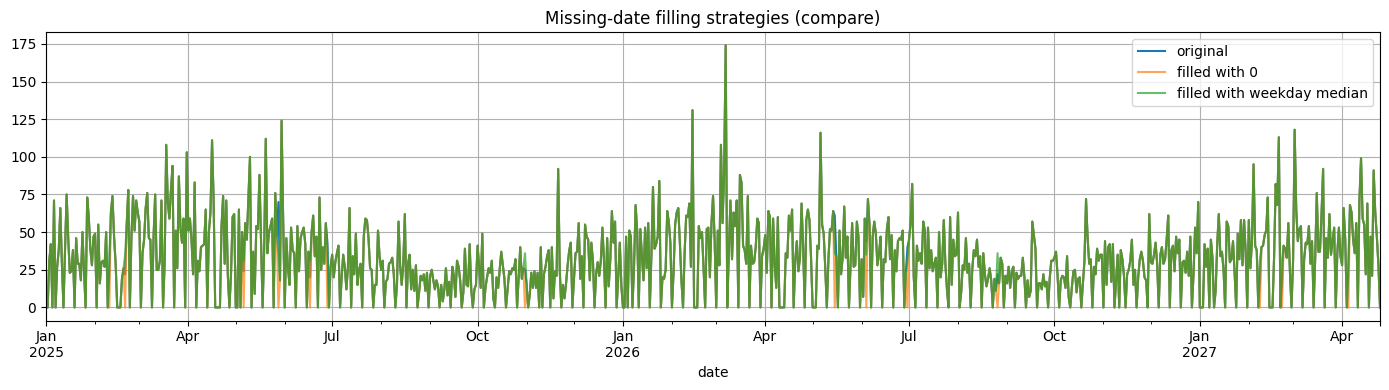

In [10]:
df_obs = df_current.copy()

missing_frac = 0.02
mask_missing = np.random.rand(len(df_obs)) < missing_frac
df_missing = df_obs.loc[~mask_missing].copy()

full_idx = pd.date_range(df_obs.index.min(), df_obs.index.max(), freq="D")
df_missing = df_missing.reindex(full_idx)

print("Missing days simulated:", int(df_missing["sales"].isna().sum()))

# Strategy A: fill missing with 0
df_fill_zero = df_missing.copy()
df_fill_zero["sales"] = df_fill_zero["sales"].fillna(0)

# Strategy B: fill missing with weekday median
df_fill_wkmed = df_missing.copy()
weekday_medians = df_obs.groupby(df_obs.index.dayofweek)["sales"].median()
wk = pd.Series(df_fill_wkmed.index.dayofweek, index=df_fill_wkmed.index)
df_fill_wkmed["sales"] = df_fill_wkmed["sales"].fillna(wk.map(weekday_medians))

plt.figure(figsize=(14, 4))
df_obs["sales"].plot(label="original")
df_fill_zero["sales"].plot(alpha=0.7, label="filled with 0")
df_fill_wkmed["sales"].plot(alpha=0.7, label="filled with weekday median")
plt.title("Missing-date filling strategies (compare)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 8) Example forecasts (ETS + Prophet)

Koristim df_train za fit, df_test za evaluaciju.
Seasonality candidates (periods): [365, 7, None]


/usr/local/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Selected HW seasonal_periods: 7
HW metrics: {'MAE': 19.31874969435956, 'RMSE': 22.20577265976725, 'MAPE%': 308.8210408781211, 'sMAPE%': 77.2132031262386}


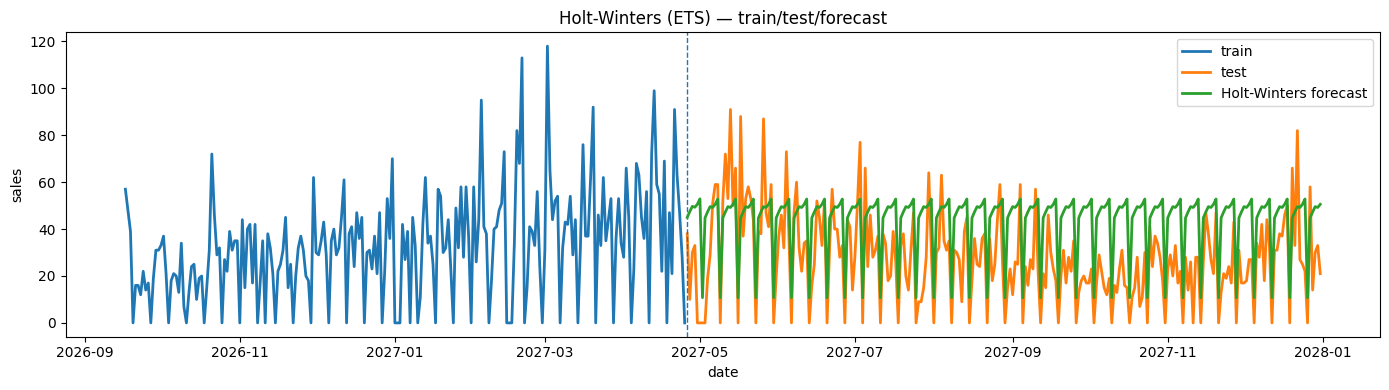

In [11]:
# 8a) Holt-Winters Exponential Smoothing (ETS) — auto izbor seasonal_periods (po RMSE ako postoji test)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# -----------------------------
# 0) Ucitaj df_current ili train/test (ako postoji)
# -----------------------------
try:
    _df = df_current
except NameError:
    raise RuntimeError("df_current is not defined. Run Section 5 (load CSV + choose range) first.")

# Prefer train/test split if you ran section 5c
if "df_train" in globals() and "df_test" in globals() and len(df_train) > 0 and len(df_test) > 0:
    _train = df_train.copy()
    _test = df_test.copy()
    HORIZON_DAYS = len(_test)
    print("Koristim df_train za fit, df_test za evaluaciju.")
else:
    _train = _df.copy()
    _test = None
    HORIZON_DAYS = 180
    print("Koristim df_current (nema df_train/df_test).")

# Ensure DateTimeIndex daily
_train = _train.sort_index().asfreq("D")
_train["sales"] = pd.to_numeric(_train["sales"], errors="coerce").fillna(0.0).clip(lower=0.0)

if _test is not None:
    _test = _test.sort_index().asfreq("D")
    _test["sales"] = pd.to_numeric(_test["sales"], errors="coerce").fillna(0.0).clip(lower=0.0)

# -----------------------------
# 1) Kandidati za seasonality (iz Step 6) + fallback
# -----------------------------
# NOTE: Holt-Winters moze da modeluje samo JEDNU sezonu (jedan seasonal_periods).
# Ako Step 6 detektuje vise sezonalnosti (npr monthly+yearly), ovde testiramo kandidate i biramo po RMSE (ako postoji test).

_period_map = {"weekly": 7, "monthly": 30, "yearly": 365}

_good = globals().get("GOOD_SEASONALITIES", [])  # npr ["yearly","monthly"]
_sel_period = globals().get("SELECTED_SEASONAL_PERIOD", None)  # None / 7 / 30 / 365

cand = []
for s in _good:
    p = _period_map.get(str(s))
    if p is not None:
        cand.append(int(p))

if _sel_period is not None:
    cand.append(int(_sel_period))

# Unique + priority order (yearly > monthly > weekly), pa na kraju None
_priority = [365, 30, 7]
cand_periods = []
for p in _priority:
    if p in cand and p not in cand_periods:
        cand_periods.append(p)
cand_periods.append(None)

print("Seasonality candidates (periods):", cand_periods)

# -----------------------------
# 2) Helpers: metrics + fit/forecast
# -----------------------------
def _metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

    smape_denom = (np.abs(y_true) + np.abs(y_pred))
    smape_denom = np.where(smape_denom == 0, 1.0, smape_denom)
    smape = float(np.mean(2.0 * np.abs(y_true - y_pred) / smape_denom) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape, "sMAPE%": smape}

def _fit_hw(train_series: pd.Series, horizon: int, seasonal_periods):
    # Za stabilnije dugorocne horizonte koristimo damped_trend=True
    if seasonal_periods is None:
        model = ExponentialSmoothing(
            train_series,
            trend="add",
            damped_trend=True,
            seasonal=None,
            initialization_method="estimated",
        )
    else:
        # Minimalno 2 pune sezone (inace je procena sezonalnosti nestabilna)
        if len(train_series) < 2 * int(seasonal_periods):
            return None
        model = ExponentialSmoothing(
            train_series,
            trend="add",
            damped_trend=True,
            seasonal="add",
            seasonal_periods=int(seasonal_periods),
            initialization_method="estimated",
        )

    fit = model.fit(optimized=True)
    fc = fit.forecast(horizon)
    return fc

# -----------------------------
# 3) Izaberi najbolji HW (po RMSE ako ima test)
# -----------------------------
best = None
best_fc = None
best_metrics = None

y_train = _train["sales"].astype(float)
y_test = _test["sales"].astype(float) if _test is not None else None

for p in cand_periods:
    fc = _fit_hw(y_train, HORIZON_DAYS, p)
    if fc is None:
        continue

    if _test is not None:
        fc = pd.Series(np.asarray(fc, dtype=float), index=_test.index, name="yhat").clip(lower=0.0)
        m = _metrics(y_test.values, fc.values)
        if (best is None) or (m["RMSE"] < best_metrics["RMSE"]):
            best = p
            best_fc = fc
            best_metrics = m
    else:
        # Nema testa: biraj SELECTED_SEASONAL_PERIOD ako postoji i validan je, inace prvi validan kandidat po prioritetu
        best = p
        future_idx = pd.date_range(_train.index.max() + pd.Timedelta(days=1), periods=HORIZON_DAYS, freq="D")
        best_fc = pd.Series(np.asarray(fc, dtype=float), index=future_idx, name="yhat").clip(lower=0.0)
        best_metrics = None
        break

if best_fc is None:
    raise RuntimeError("Holt-Winters nije uspeo da se fituje ni za jedan kandidat (proveri duzinu treninga i period).")

print("Selected HW seasonal_periods:", best)
if best_metrics is not None:
    print("HW metrics:", best_metrics)

# -----------------------------
# 4) Export globals (za Section 9)
# -----------------------------
holt_winters_fc = best_fc
# Backward-compat: Section 9 je ranije citao ets_fc
ets_fc = holt_winters_fc

# -----------------------------
# 5) Plot
# -----------------------------
VIEW_LAST_N = 220
train_view_start = _train.index.max() - pd.Timedelta(days=VIEW_LAST_N)

plt.figure(figsize=(14, 4))
plt.plot(_train.loc[train_view_start:].index, _train.loc[train_view_start:, "sales"].values, label="train", linewidth=2)

if _test is not None:
    plt.plot(_test.index, _test["sales"].values, label="test", linewidth=2)
    plt.axvline(_test.index.min(), linestyle="--", linewidth=1)

plt.plot(holt_winters_fc.index, holt_winters_fc.values, label="Holt-Winters forecast", linewidth=2)
plt.title("Holt-Winters (ETS) — train/test/forecast")
plt.xlabel("date")
plt.ylabel("sales")
plt.legend()
plt.tight_layout()
plt.show()


08:01:34 - cmdstanpy - INFO - Chain [1] start processing
08:01:34 - cmdstanpy - INFO - Chain [1] done processing


Koristim df_train za fit, df_test za evaluaciju.
Good seasonalities from Step 6: ['yearly', 'weekly']
Prophet metrics: {'MAE': 9.729320414522444, 'RMSE': 13.732908978808029, 'MAPE%': 126.1544647310368}


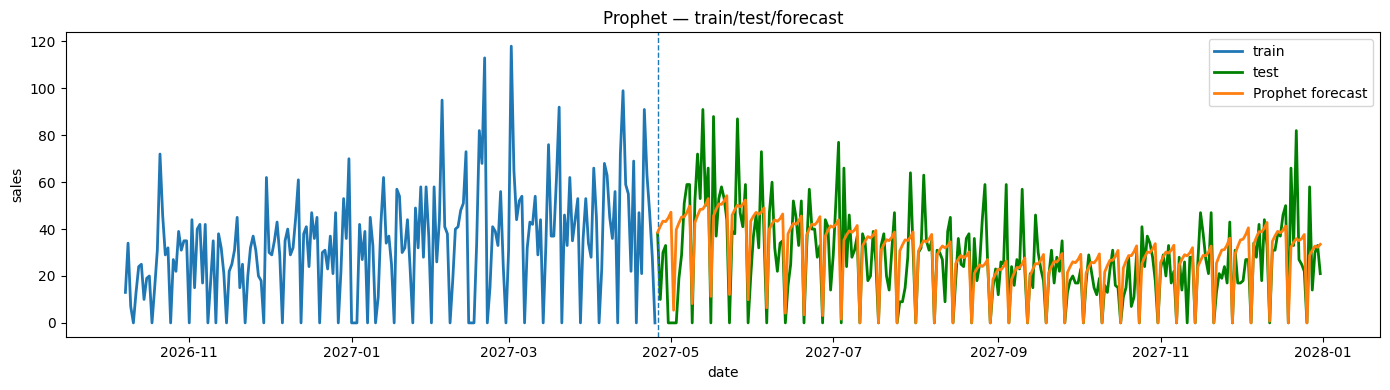

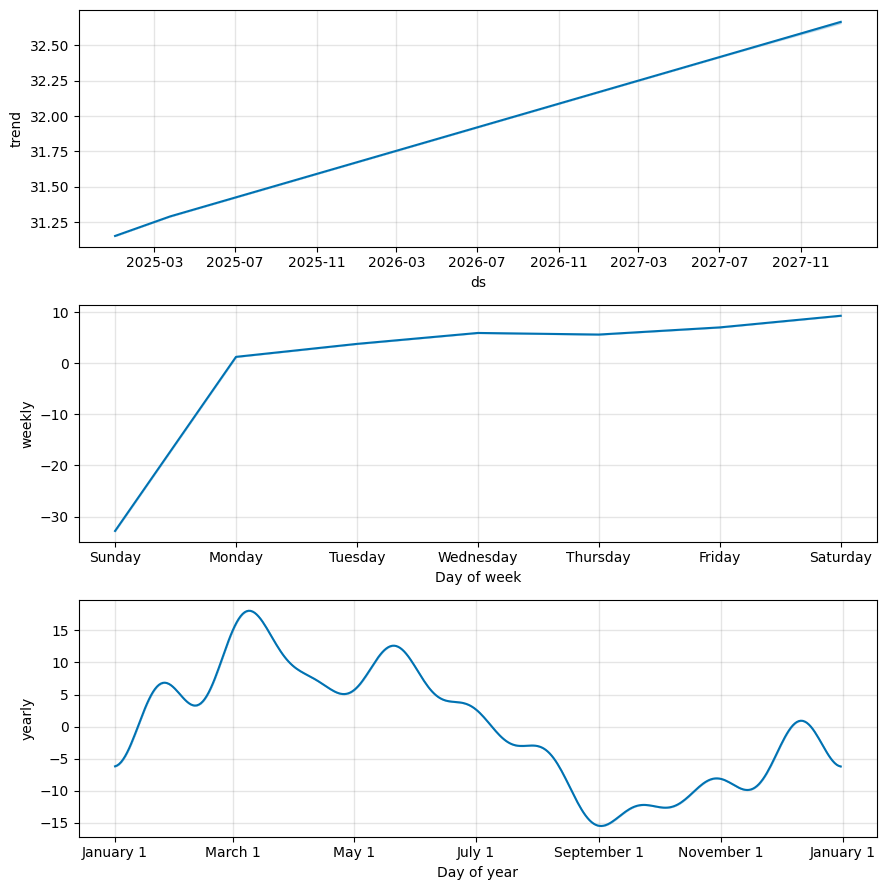

In [12]:
# 8b) Prophet — enable ALL "good" seasonalities from Step 6 (can be multiple)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from prophet import Prophet
except Exception as e:
    raise RuntimeError("Prophet is not available. Install with: pip install prophet") from e

try:
    _df = df_current
except NameError:
    raise RuntimeError("df_current is not defined. Run Section 5 (load CSV + choose range) first.")

# Prefer train/test split if you ran section 5c
if "df_train" in globals() and "df_test" in globals() and len(df_train) > 0 and len(df_test) > 0:
    _train = df_train.copy()
    _test = df_test.copy()
    HORIZON_DAYS = len(_test)
    print("Koristim df_train za fit, df_test za evaluaciju.")
else:
    _train = _df.copy()
    _test = None
    HORIZON_DAYS = 180
    print("Koristim df_current (nema df_train/df_test).")

_train = _train.sort_index().asfreq("D")
_train["sales"] = _train["sales"].astype(float).fillna(0.0).clip(lower=0.0)

if _test is not None:
    _test = _test.sort_index().asfreq("D")
    _test["sales"] = _test["sales"].astype(float).fillna(0.0).clip(lower=0.0)

GOOD = globals().get("GOOD_SEASONALITIES", [])
print("Good seasonalities from Step 6:", GOOD)

if GOOD:
    m = Prophet(
        yearly_seasonality=("yearly" in GOOD),
        weekly_seasonality=("weekly" in GOOD),
        daily_seasonality=False,
    )
else:
    # If Step 6 didn't confirm anything, keep Prophet's defaults (auto) instead of forcing none.
    m = Prophet(
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality=False,
    )

# Monthly is not built-in -> add custom monthly if detected as good
if "monthly" in GOOD:
    m.add_seasonality(name="monthly", period=30.5, fourier_order=5)

# Build Prophet input with required columns: ds (datetime), y (numeric)
def _to_prophet_df(obj, y_col: str = "sales") -> pd.DataFrame:
    if isinstance(obj, pd.Series):
        obj = obj.to_frame(name=y_col)

    df = obj.copy()

    # Find target column
    if y_col not in df.columns:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not numeric_cols:
            raise ValueError(f"Prophet: can't find numeric target column. Columns: {list(df.columns)}")
        y_col = numeric_cols[0]

    # Case 1: datetime index (preferred)
    if isinstance(df.index, pd.DatetimeIndex):
        out = df[[y_col]].reset_index()
        out.columns = ["ds", "y"]
    else:
        # Case 2: look for an existing date column
        date_col = None
        for c in ["ds", "date", "Date", "timestamp", "time"]:
            if c in df.columns:
                date_col = c
                break

        if date_col is None:
            tmp = df.reset_index()
            date_col = tmp.columns[0]
            out = tmp[[date_col, y_col]].rename(columns={date_col: "ds", y_col: "y"})
        else:
            out = df[[date_col, y_col]].rename(columns={date_col: "ds", y_col: "y"})

    out["ds"] = pd.to_datetime(out["ds"], errors="coerce")
    # Ensure tz-naive datetimes for Prophet
    try:
        out["ds"] = out["ds"].dt.tz_localize(None)
    except Exception:
        pass

    out["y"] = pd.to_numeric(out["y"], errors="coerce")
    out = out.dropna(subset=["ds", "y"]).sort_values("ds")

    if out.shape[0] < 2:
        raise ValueError("Prophet: not enough valid rows after ds/y conversion.")
    return out

df_prophet = _to_prophet_df(_train, y_col="sales")
m.fit(df_prophet)

future = m.make_future_dataframe(periods=HORIZON_DAYS, freq="D")
fcst = m.predict(future).set_index("ds")

# Build forecast series aligned to test (if exists)
if _test is not None:
    yhat = fcst.loc[_test.index, "yhat"].clip(lower=0.0)
    yhat = pd.Series(yhat.values, index=_test.index, name="yhat")
else:
    yhat = fcst["yhat"].iloc[-HORIZON_DAYS:].clip(lower=0.0)
    yhat = pd.Series(yhat.values, index=yhat.index, name="yhat")

def _metrics(y_true: pd.Series, y_pred: pd.Series):
    y_true = y_true.astype(float).values
    y_pred = y_pred.astype(float).values
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

if _test is not None:
    print("Prophet metrics:", _metrics(_test["sales"].loc[yhat.index], yhat))

# Plot: train vs test vs forecast (yhat)
VIEW_LAST_TRAIN_DAYS = 200
train_view_start = max(_train.index.min(), _train.index.max() - pd.Timedelta(days=VIEW_LAST_TRAIN_DAYS - 1))

plt.figure(figsize=(14, 4))
plt.plot(_train.loc[train_view_start:].index, _train.loc[train_view_start:, "sales"].values, label="train", linewidth=2)

if _test is not None:
    plt.plot(_test.index, _test["sales"].values, label="test", linewidth=2, color="green")
    plt.axvline(_test.index.min(), linestyle="--", linewidth=1)

plt.plot(yhat.index, yhat.values, label="Prophet forecast", linewidth=2)
plt.title("Prophet — train/test/forecast")
plt.xlabel("date")
plt.ylabel("sales")
plt.legend()
plt.tight_layout()
plt.show()

# Components plot (trend + seasonality)
_ = m.plot_components(fcst.reset_index())

### 8c) ARIMA, Linear Regression i XGBoost (lag feature modeli)

U 8c je svaka metoda podeljena na **logiku** i **grafik**:
- **Linear Regression**: 8c-1a (logika) + 8c-1b (grafik)
- **XGBoost**: 8c-2a (logika) + 8c-2b (grafik)
- **ARIMA/SARIMAX**: 8c-3a (logika) + 8c-3b (grafik)

Na kraju (8d) dobijaš **Plotly** grafikon gde možeš:
- da zumiraš izborom datuma (range slider / drag-select)
- da uključuješ/isključuješ modele (toggle dugmad + legenda)


In [13]:
# 8c-0) Zajednička priprema (df_train/df_test + feature funkcije + metrics)
# Očekuje da si već pokrenuo 5c (train/test split), pa imaš df_train i df_test.

import numpy as np
import pandas as pd

# -----------------------------
# 0) Učitaj train/test (strogo)
# -----------------------------
if "df_train" not in globals() or "df_test" not in globals():
    raise RuntimeError("df_train / df_test nisu definisani. Pokreni 5c (podela na trening/test) pre 8c.")

_train = df_train.copy()
_test  = df_test.copy()

if "sales" not in _train.columns or "sales" not in _test.columns:
    raise RuntimeError("Očekujem kolonu 'sales' u df_train i df_test. Proveri CSV format.")

# -----------------------------
# 1) Helper: obezbedi dnevni indeks bez rupa (missing days -> sales=0)
# -----------------------------
def ensure_daily(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy().sort_index()
    df = df[~df.index.duplicated(keep="last")]

    start, end = df.index.min(), df.index.max()
    full = pd.date_range(start, end, freq="D")

    df = df.reindex(full)
    df.index.name = "date"

    # Sales: missing -> 0
    df["sales"] = pd.to_numeric(df["sales"], errors="coerce").fillna(0.0)

    # Ostale kolone (ako postoje): stabilno popunjavanje bez FutureWarning/Downcasting warning-a
    for col in df.columns:
        if col == "sales":
            continue

        s = df[col]

        # "boolean-ish": dozvoljene vrednosti {0,1,True,False} (+ NaN)
        try:
            is_boolish = s.dropna().isin([0, 1, True, False]).all()
        except Exception:
            is_boolish = False

        if is_boolish:
            # Pretvori object 0/1 u numeric pa u bool, pa popuni NaN -> False
            if s.dtype == object:
                s_num = pd.to_numeric(s, errors="coerce")
                if s_num.notna().any():
                    s = s_num
            s = s.fillna(0).astype(int).astype(bool)
            df[col] = s
        else:
            # Za "numeric-ish" ili druge kolone: ffill pa 0
            if s.dtype == object:
                s = s.infer_objects(copy=False)
            df[col] = s.ffill().fillna(0)

    return df

_train_d = ensure_daily(_train)
_test_d  = ensure_daily(_test)

train_series = _train_d["sales"].astype(float)

# -----------------------------
# 2) Feature engineering (lag modeli)
# -----------------------------
LAGS  = [1, 7, 14, 30]
ROLLS = [7, 14]

def make_features_from_history(history: pd.Series, ts: pd.Timestamp) -> dict:
    """Feature vektor za datum ts koristeći SAMO istoriju do ts-1."""
    feats = {}
    feats["dow"] = int(ts.dayofweek)
    feats["month"] = int(ts.month)
    feats["dayofyear"] = int(ts.dayofyear)

    for l in LAGS:
        feats[f"lag_{l}"] = float(history.iloc[-l]) if len(history) >= l else 0.0

    for k in ROLLS:
        feats[f"roll_mean_{k}"] = float(history.iloc[-k:].mean()) if len(history) >= k else 0.0

    return feats

def build_supervised(df_daily: pd.DataFrame):
    """X, y iz dnevnog df: y(t)=sales(t), feature-i koriste prošlost."""
    y = df_daily["sales"].astype(float)

    max_need = max(LAGS + ROLLS)
    X_rows, y_rows, idx_rows = [], [], []

    for i in range(max_need, len(df_daily)):
        ts = df_daily.index[i]
        hist = y.iloc[:i]  # do ts-1
        feats = make_features_from_history(hist, ts)
        X_rows.append(feats)
        y_rows.append(float(y.iloc[i]))
        idx_rows.append(ts)

    X = pd.DataFrame(X_rows, index=pd.DatetimeIndex(idx_rows))
    y_out = pd.Series(y_rows, index=pd.DatetimeIndex(idx_rows), name="y")
    return X, y_out

def recursive_forecast(model, history: pd.Series, start_date: pd.Timestamp, periods: int, feature_columns=None) -> pd.Series:
    """Rekurzivna prognoza: svaki dan koristi prethodno predviđene vrednosti kao 'istoriju'."""
    hist = history.copy()
    preds, dates = [], []
    cur = pd.Timestamp(start_date)

    for _ in range(periods):
        feats = make_features_from_history(hist, cur)
        if feature_columns is not None:
            X1 = pd.DataFrame([feats], columns=feature_columns)
        else:
            X1 = pd.DataFrame([feats])
        yhat = float(model.predict(X1)[0])
        yhat = max(0.0, yhat)  # clamp
        preds.append(yhat)
        dates.append(cur)
        hist = pd.concat([hist, pd.Series([yhat], index=[cur])])
        cur = cur + pd.Timedelta(days=1)

    return pd.Series(preds, index=pd.DatetimeIndex(dates), name="yhat")

# -----------------------------
# 3) Metrics
# -----------------------------
def metrics(y_true: pd.Series, y_pred: pd.Series) -> dict:
    y_true = y_true.astype(float).values
    y_pred = y_pred.astype(float).values
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

# Global containers (koristi 8c-1a/2a/3a i 8d)
results = {}
model_metrics = {}

# Forecast horizon = test length
forecast_start = _test_d.index.min()
horizon = len(_test_d)

print(f"Train rows: {len(_train_d)} | Test rows: {len(_test_d)} | forecast_start={forecast_start.date()} | horizon={horizon}")


Train rows: 845 | Test rows: 250 | forecast_start=2027-04-26 | horizon=250


In [14]:
# 8c-1a) Linear Regression — logika (fit + prognoza + metrike)

from sklearn.linear_model import LinearRegression

X_train, y_train = build_supervised(_train_d)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

pred_lin = recursive_forecast(lin_model, train_series, forecast_start, horizon, feature_columns=list(X_train.columns))
results["Linear"] = pred_lin

# metrike na test opsegu
y_true = _test_d["sales"].astype(float)
model_metrics["Linear"] = metrics(y_true.loc[pred_lin.index], pred_lin)

print("Linear metrics:", model_metrics["Linear"])


Linear metrics: {'MAE': 13.651543120333521, 'RMSE': 17.304072771191684, 'MAPE%': 241.0301914273589}


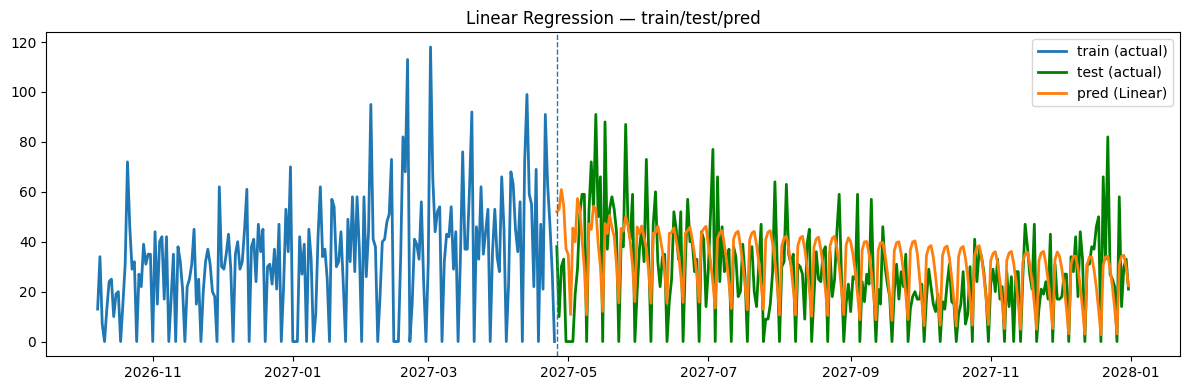

In [15]:
# 8c-1b) Linear Regression — grafik (train/test/pred)

import matplotlib.pyplot as plt

VIEW_LAST_TRAIN_DAYS = 200  # promeni po želji

train_view_start = max(_train_d.index.min(), _train_d.index.max() - pd.Timedelta(days=VIEW_LAST_TRAIN_DAYS-1))
tr = _train_d.loc[train_view_start:]
te = _test_d.copy()
pred = results["Linear"]

plt.figure(figsize=(12, 4))
plt.plot(tr.index, tr["sales"].values, label="train (actual)", linewidth=2)
plt.plot(te.index, te["sales"].values, label="test (actual)", linewidth=2, color="green")
plt.plot(pred.index, pred.values, label="pred (Linear)", linewidth=2)
plt.axvline(te.index.min(), linestyle="--", linewidth=1)
plt.title("Linear Regression — train/test/pred")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# 8c-2a) XGBoost — logika (fit + prognoza + metrike)

from xgboost import XGBRegressor

X_train, y_train = build_supervised(_train_d)

xgb_model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=4,
)

xgb_model.fit(X_train, y_train)

pred_xgb = recursive_forecast(xgb_model, train_series, forecast_start, horizon, feature_columns=list(X_train.columns))
results["XGBoost"] = pred_xgb

y_true = _test_d["sales"].astype(float)
model_metrics["XGBoost"] = metrics(y_true.loc[pred_xgb.index], pred_xgb)

print("XGBoost metrics:", model_metrics["XGBoost"])


XGBoost metrics: {'MAE': 10.221700852692127, 'RMSE': 14.71129618157999, 'MAPE%': 105.3661986923948}


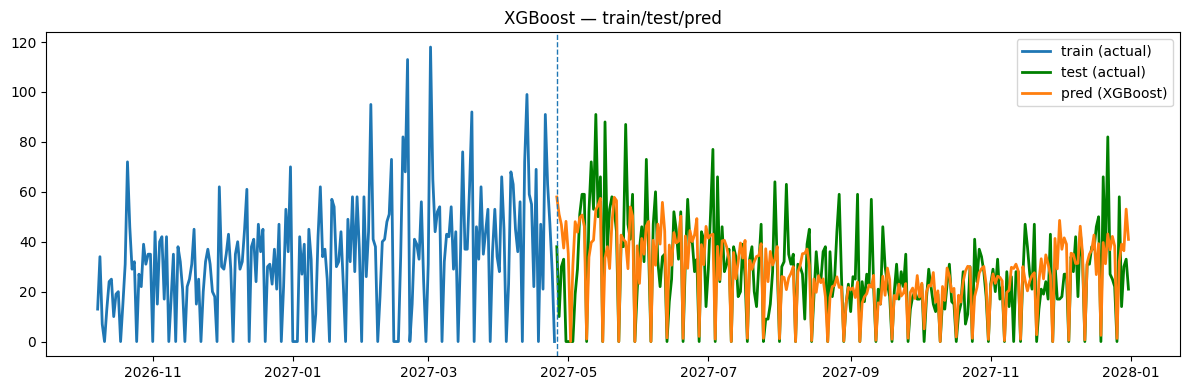

In [17]:
# 8c-2b) XGBoost — grafik (train/test/pred)

import matplotlib.pyplot as plt

VIEW_LAST_TRAIN_DAYS = 200

train_view_start = max(_train_d.index.min(), _train_d.index.max() - pd.Timedelta(days=VIEW_LAST_TRAIN_DAYS-1))
tr = _train_d.loc[train_view_start:]
te = _test_d.copy()
pred = results["XGBoost"]

plt.figure(figsize=(12, 4))
plt.plot(tr.index, tr["sales"].values, label="train (actual)", linewidth=2)
plt.plot(te.index, te["sales"].values, label="test (actual)", linewidth=2, color="green")
plt.plot(pred.index, pred.values, label="pred (XGBoost)", linewidth=2)
plt.axvline(te.index.min(), linestyle="--", linewidth=1)
plt.title("XGBoost — train/test/pred")
plt.legend()
plt.tight_layout()
plt.show()


## 9) Uporedjivanje svih modela (tabela + Plotly graf)

Ovaj deo skuplja prognoze iz sekcije 8 (Holt-Winters (ETS), Prophet) i 8c (Linear, XGBoost, + bilo koji dodatni model u `results`) i pravi:
- **tabelu metrika** (MAE, RMSE, MAPE, sMAPE)
- **Plotly graf** gde su svi modeli uporedjeni na test periodu


In [18]:

# 9) Model comparison — unified table + Plotly overlay

import numpy as np
import pandas as pd
import plotly.graph_objects as go

# -----------------------------
# 0) Preconditions (need test set)
# -----------------------------
if "df_train" not in globals() or "df_test" not in globals():
    raise RuntimeError("Za Section 9 je potreban train/test split. Pokreni 5c (podela na trening/test) pre Section 9.")

_train_all = df_train.copy()
_test_all  = df_test.copy()

# Ensure daily DateTimeIndex + numeric sales
_train_all = _train_all.sort_index().asfreq("D")
_test_all  = _test_all.sort_index().asfreq("D")

_train_all["sales"] = pd.to_numeric(_train_all["sales"], errors="coerce").fillna(0.0).clip(lower=0.0)
_test_all["sales"]  = pd.to_numeric(_test_all["sales"], errors="coerce").fillna(0.0).clip(lower=0.0)

y_true = _test_all["sales"].astype(float)

# -----------------------------
# 1) Helpers
# -----------------------------
def _to_series(x) -> pd.Series:
    if isinstance(x, pd.Series):
        s = x.copy()
    elif isinstance(x, pd.DataFrame):
        # try common column names
        for col in ["yhat", "forecast", "pred", "prediction", "sales", "y"]:
            if col in x.columns:
                s = x[col].copy()
                break
        else:
            raise ValueError("DataFrame predikcija nema prepoznatljiv kolonu (yhat/forecast/pred/...).")
    else:
        s = pd.Series(x)

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)

    s = s.sort_index()
    s.name = "yhat"
    return s

def _align_to_test(pred: pd.Series, test_index: pd.DatetimeIndex) -> pd.Series:
    s = _to_series(pred)

    # Clamp negatives to 0 (sales cannot be negative)
    s = s.astype(float).clip(lower=0.0)

    # Reindex to the full test index (missing dates -> NaN)
    return s.reindex(test_index)

def _metrics(y_true: pd.Series, y_pred: pd.Series) -> dict:
    mask = y_true.notna() & y_pred.notna()
    yt = y_true.loc[mask].astype(float).values
    yp = y_pred.loc[mask].astype(float).values

    if len(yt) == 0:
        return {"N": 0, "MAE": np.nan, "RMSE": np.nan, "MAPE%": np.nan, "sMAPE%": np.nan}

    mae = float(np.mean(np.abs(yt - yp)))
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))

    denom = np.where(yt == 0, 1.0, yt)
    mape = float(np.mean(np.abs((yt - yp) / denom)) * 100.0)

    smape_denom = (np.abs(yt) + np.abs(yp))
    smape_denom = np.where(smape_denom == 0, 1.0, smape_denom)
    smape = float(np.mean(2.0 * np.abs(yt - yp) / smape_denom) * 100.0)

    return {"N": int(mask.sum()), "MAE": mae, "RMSE": rmse, "MAPE%": mape, "sMAPE%": smape}

# -----------------------------
# 2) Collect predictions from Step 8 / 8c
# -----------------------------
preds = {}

# Holt-Winters / ETS (8a)
if "holt_winters_fc" in globals():
    preds["Holt-Winters"] = _align_to_test(holt_winters_fc, y_true.index)
elif "ets_fc" in globals():
    preds["ETS"] = _align_to_test(ets_fc, y_true.index)

# Prophet (8b)
if "yhat" in globals():
    preds["Prophet"] = _align_to_test(yhat, y_true.index)

# 8c models (Linear/XGBoost/...)
if "results" in globals() and isinstance(results, dict):
    for name, pred in results.items():
        try:
            preds[str(name)] = _align_to_test(pred, y_true.index)
        except Exception as e:
            print(f"[WARN] Preskacem model '{name}' (ne mogu da poravnam predikcije): {e}")

if not preds:
    raise RuntimeError("Nema pronadjenih predikcija. Pokreni Section 8 i 8c pre Section 9 (ETS/Prophet + lag modeli).")

# -----------------------------
# 3) Build metrics table
# -----------------------------
rows = []
for name, pred in preds.items():
    m = _metrics(y_true, pred)
    rows.append({"Model": name, **m})

metrics_df = pd.DataFrame(rows).set_index("Model")
metrics_df = metrics_df.sort_values("RMSE", ascending=True)

print("Model metrics (sorted by RMSE):")
display(metrics_df)

best_model = metrics_df.index[0]
print(f"Best (lowest RMSE): {best_model}")

# -----------------------------
# 4) Plotly overlay (train tail + test + all forecasts)
# -----------------------------
VIEW_LAST_TRAIN_DAYS = int(globals().get("VIEW_LAST_TRAIN_DAYS", 200))
train_view_start = max(_train_all.index.min(), _train_all.index.max() - pd.Timedelta(days=VIEW_LAST_TRAIN_DAYS - 1))
train_view = _train_all.loc[train_view_start:, "sales"]

fig = go.Figure()

# Train tail
fig.add_trace(go.Scatter(
    x=train_view.index, y=train_view.values,
    mode="lines", name=f"train (last {VIEW_LAST_TRAIN_DAYS}d)"
))

# Test actual
fig.add_trace(go.Scatter(
    x=y_true.index, y=y_true.values,
    mode="lines", name="test (actual)"
))

# Vertical split marker
fig.add_vline(x=y_true.index.min(), line_dash="dash")

# Forecasts
for name, pred in preds.items():
    fig.add_trace(go.Scatter(
        x=pred.index, y=pred.values,
        mode="lines", name=f"{name} forecast"
    ))

fig.update_layout(
    title=f"Model comparison — test forecast overlay (best RMSE: {best_model})",
    xaxis_title="date",
    yaxis_title="sales",
    hovermode="x unified",
    legend_title="series",
    height=520,
)

fig.show()


Model metrics (sorted by RMSE):


,N,MAE,RMSE,MAPE%,sMAPE%
Model,,,,,
Prophet,250,9.729320,13.732909,126.154465,39.482380
XGBoost,250,10.221701,14.711296,105.366199,51.409750
Linear,250,13.651543,17.304073,241.030191,67.271305
Holt-Winters,250,19.318750,22.205773,308.821041,77.213203


Best (lowest RMSE): Prophet
